In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

Transfer Learning for Computer Vision Tutorial
==============================================

**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural
network for image classification using transfer learning. You can read
more about the transfer learning at [cs231n
notes](https://cs231n.github.io/transfer-learning/)

Quoting these notes,

> In practice, very few people train an entire Convolutional Network
> from scratch (with random initialization), because it is relatively
> rare to have a dataset of sufficient size. Instead, it is common to
> pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
> contains 1.2 million images with 1000 categories), and then use the
> ConvNet either as an initialization or a fixed feature extractor for
> the task of interest.

These two major transfer learning scenarios look as follows:

-   **Finetuning the ConvNet**: Instead of random initialization, we
    initialize the network with a pretrained network, like the one that
    is trained on imagenet 1000 dataset. Rest of the training looks as
    usual.
-   **ConvNet as fixed feature extractor**: Here, we will freeze the
    weights for all of the network except that of the final fully
    connected layer. This last fully connected layer is replaced with a
    new one with random weights and only this layer is trained.


In [3]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim #提供优化器模块（如 SGD, Adam），用于更新模型参数
from torch.optim import lr_scheduler #动态调整优化器的学习率
import torch.backends.cudnn as cudnn #cudnn: NVIDIA 的GPU加速库，用于加速深度学习中的卷积计算
import numpy as np
import torchvision
# datasets: 提供常见数据集加载工具（如 CIFAR, ImageNet）
# models：包含预训练模型（如 ResNet, VGG）
# transforms：用于数据增强和预处理
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image #Python 图像处理库，用于加载和操作图像数据
from tempfile import TemporaryDirectory #临时文件夹模块，适合在测试阶段存储临时文件或模型

cudnn.benchmark = True #通过启用 cuDNN 的自动调优功能，加速卷积运算
plt.ion()   # interactive mode
# 使Matplotlib能够实时更新绘图窗口。适用于在训练过程中实时显示数据（例如损失、准确率）

Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants
and bees. There are 75 validation images for each class. Usually, this
is a very small dataset to generalize upon, if trained from scratch.
Since we are using transfer learning, we should be able to generalize
reasonably well.

This dataset is a very small subset of imagenet.


In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #随机裁剪图像，并将其调整为 224x224 大小，模拟不同场景下的物体尺度变化
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(), #随机水平翻转图像，增强数据多样性
        transforms.ToTensor(),       # (C, H, W)
        #使用给定均值 [0.485, 0.456, 0.406]
        #和标准差 [0.229, 0.224, 0.225] 对图像归一化
        #这些值是 ImageNet 数据集的通用标准
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),    #将图像的最短边调整为 256 像素
        transforms.CenterCrop(224),  #从中心裁剪, 并放缩为224x224 的图像
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) #预处理
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']} #num_workers=4：启用4个子进程来并行加载数据
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


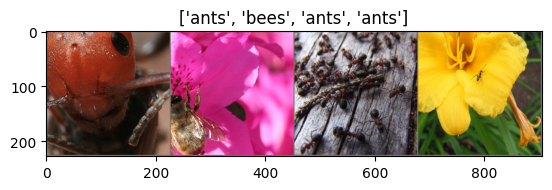

In [5]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) #将输入张量转换为NumPy数组，（C，H，W）→（H，W，C）
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean #把归一化后的图像还原
    inp = np.clip(inp, 0, 1) #将图像像素值限制在[0,1]范围内，确保显示图像时颜色值有效
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated， 适用于交互式模式


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
'''
inputs：一个批次的图像张量，形状为 (batch_size, 3, H, W)。
classes：一个批次的类别标签，形状为 (batch_size,)
'''

# Make a grid from batch
out = torchvision.utils.make_grid(inputs) #将一个批次的图像张量排列成一个网格，默认网格排列为行优先
# 输出一个包含多个图像的网格张量，形状为(3, H, W)

imshow(out, title=[class_names[x] for x in classes])

Training the model
==================

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  #criterion：损失函数，用于计算预测与真实值之间的误差。
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        # state_dict()：键是模型中每个参数的名称（如层名称），值是参数的值
        '''
        1. 保存模型的状态字典：将model.state_dict() 保存到指定路径best_model_params_path。
        状态字典是一个 OrderedDict，包含了模型的所有可学习参数（如权重和偏置）及其当前值。
        2. 只保存参数，不包括模型结构，这种方式通常用来在训练期间或训练完成后保存模型的权重。
        '''
        best_acc = 0.0 #用于跟踪验证集的最高精度。

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}') #打印进度
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                #初始化变量，累积当前epoch损失（running_loss）
                #和预测正确的样本数量（running_corrects）
                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    #获取输入和标签，传递到设备
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):#仅在训练阶段启用梯度计算
                        outputs = model(inputs)
                        #获取模型输出中每个样本的预测类别索引
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                #计算当前阶段的平均损失和准确率
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
                    #仅在验证阶段，如果当前精度高于最佳精度，保存模型参数

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}') #打印最佳验证精度

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training #检查模型当前是否处于训练模式
    model.eval()
    images_so_far = 0 #记录已经可视化的图像数量
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) #预测类别索引

            for j in range(inputs.size()[0]): #inputs.size()[0]：获取当前批次的图片数量
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off') #隐藏坐标轴
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j]) #从 GPU 转回 CPU，且转换为 NumPy

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [10]:
model_ft = models.resnet18(weights='IMAGENET1K_V1') #加载ResNet-18结构。使用在ImageNet数据集上预训练的权重。
num_ftrs = model_ft.fc.in_features #提取最后一层的输入特征数（通常为 512）
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2) #用于分类的全连接层

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss() #用于分类任务的交叉熵损失函数
#输入是未归一化的 logits（预测值）。输出是类别索引的标签

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs （每隔step_size个epoch，将学习率乘以gamma）
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 33.5MB/s]


Train and evaluate
==================

It should take around 15-25 min on CPU. On GPU though, it takes less
than a minute.


In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5509 Acc: 0.6967
val Loss: 0.2384 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.6013 Acc: 0.7336
val Loss: 0.3559 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.4382 Acc: 0.8197
val Loss: 0.3016 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.4199 Acc: 0.8443
val Loss: 0.3061 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.4780 Acc: 0.7787
val Loss: 0.4786 Acc: 0.8562

Epoch 5/24
----------
train Loss: 0.5692 Acc: 0.7869
val Loss: 0.4752 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.4057 Acc: 0.7992
val Loss: 0.3519 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.5666 Acc: 0.7951
val Loss: 0.2050 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3234 Acc: 0.8607
val Loss: 0.1904 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3038 Acc: 0.8607
val Loss: 0.2264 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.2383 Acc: 0.9221
val Loss: 0.1876 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2779 Acc: 0.8893
val Loss: 0.1978 Acc: 0.9281

Ep

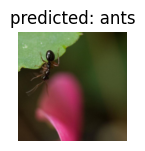

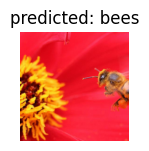

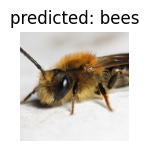

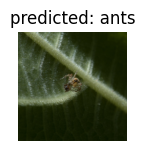

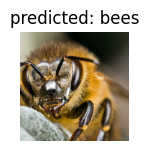

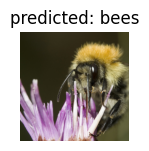

In [12]:
visualize_model(model_ft) #随机选择若干张图片，显示其图像、预测类别以及对应的标签

ConvNet as fixed feature extractor
==================================

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [13]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False #冻结模型所有参数的梯度更新，减少计算量并保留预训练权重

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
==================

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don\'t need to be computed for most of the
network. However, forward does need to be computed.


In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6396 Acc: 0.6066
val Loss: 0.3334 Acc: 0.8431

Epoch 1/24
----------
train Loss: 0.6609 Acc: 0.7090
val Loss: 0.4045 Acc: 0.7974

Epoch 2/24
----------
train Loss: 0.4916 Acc: 0.7869
val Loss: 0.2884 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.5290 Acc: 0.8074
val Loss: 0.2376 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.4736 Acc: 0.8033
val Loss: 0.5926 Acc: 0.7778

Epoch 5/24
----------
train Loss: 0.7274 Acc: 0.7213
val Loss: 0.2382 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.3753 Acc: 0.8402
val Loss: 0.2648 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.4428 Acc: 0.7869
val Loss: 0.1783 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3547 Acc: 0.8525
val Loss: 0.1938 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3828 Acc: 0.8197
val Loss: 0.1970 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4001 Acc: 0.8402
val Loss: 0.2008 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3208 Acc: 0.8607
val Loss: 0.1816 Acc: 0.9412

Ep

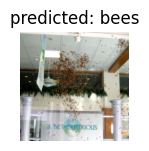

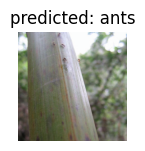

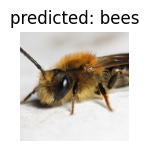

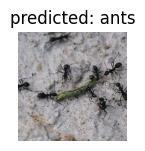

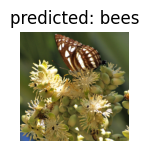

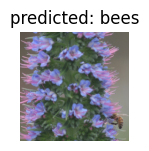

In [15]:
visualize_model(model_conv)

plt.ioff() #关闭Matplotlib的交互模式
plt.show() #在非交互模式下，plt.show() 确保所有绘图内容都呈现出来

Inference on custom images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


In [16]:
def visualize_model_predictions(model,img_path):
    was_training = model.training #记录模型的当前状态
    model.eval()

    img = Image.open(img_path) #加载指定路径的图像
    img = data_transforms['val'](img) #应用数据增强，将图像转换为适合模型输入的格式。
    img = img.unsqueeze(0) #在最前面添加一个维度，形状从[C, H, W]变为[1, C, H, W]，模拟批量输入。
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

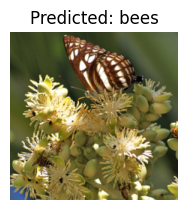

In [18]:
visualize_model_predictions(
    model_conv, #利用模型进行推理，预测类别，并可视化图像及其预测结果
    img_path='/content/drive/MyDrive/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

Further Learning
================

If you would like to learn more about the applications of transfer
learning, checkout our [Quantized Transfer Learning for Computer Vision
Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).
